<div style="width:90%; margin:0 auto; background-color:#F0F0F0; padding:20px; border-radius:8px; font-family:Arial, sans-serif">

<div style="display:flex; align-items:center; justify-content:space-between; margin-bottom:15px">
    <div style="width:100px; height:100px">
        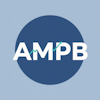
    </div>
    <div style="text-align:center; margin-bottom:20px">
        <h1 style="color:#9E0B0F; font-size:26px; margin-bottom:5px">Análisis de modelos predictivos en bolsa</h1>
        <h3 style="color:#D64550; font-size:22px; margin-top:0">Copyright (C) 2024-2025 MegaStorm Systems</h3>
    </div>
    <div style="width:192px; height:59px">
        <p style="max-width:100%; max-height:100%">
    </div>
</div>

<div style="width:60%; margin:0 auto; background-color:#E8E8E8; padding:20px; border-radius:10px; border:1px solid #D0D0D0; margin-bottom:20px; color:#333333; line-height:1.5; box-shadow:0 2px 4px rgba(0,0,0,0.05)">
    <p style="margin:0; font-size:15px">    
    This software is provided "as-is", without any express or implied<br>
    warranty. In no event will the authors be held liable for any damages<br>
    arising from the use of this software.<br><br>
    Permission is granted to anyone to use this software for any purpose,<br>
    including commercial applications, and to alter it and redistribute it<br>
    freely, subject to the following restrictions:<br><br>
    1. The origin of this software must not be misrepresented; you must not<br>
    claim that you wrote the original software. If you use this software<br>
    in a product, an acknowledgment in the product documentation would be<br>
    appreciated but is not required.<br>
    2. Altered source versions must be plainly marked as such, and must not be<br>
    misrepresented as being the original software.<br>
    3. This notice may not be removed or altered from any source distribution.
    </p>
</div>

<div style="text-align:center">
    <h2 style="font-size:24px; color:#9E0B0F; margin:0">Predictor Random Forest v1.3</h2>
</div>

</div>

In [ ]:
# Importar librerías
import os
import argparse
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from itertools import product
import time
from ampblib import AMPBConfig, processData, generateEvaluation, updateNextDayExog, createReport, getExogVars, reverseTransformPredictions, createModelIdentity

In [ ]:
# 0. PARÁMETROS CONFIGURABLES

model_name = "RandomForest"
model_version = "v1.3"

# Por defecto, permite ejecución interactiva
default_exog_set_id = 16    # 1="Directos", 2="IndicadoresTecnicos", 3="BigTech", 4="IndicesBursatiles", 5="IndicadoresEconomicos", 6="AnalisisSentimiento"

# Estos son fijos e internos
nombre_archivo = "NVDA_2015-01-05_2025-05-23_SA.csv"
test_size = 60              # Número de días para el conjunto de test
optimize_params = True      # True para optimizar con búsqueda manual, False para usar valores fijos
run_backtesting = True      # True para Backtesting con Walk-Forward
retrain_interval = 1        # Reentrenar modelo completo cada n días en backtesting. 5 es un valor adecuado, acelera la velocidad a cambio de perder un ~6% de rendimiento.

# No utilizamos transformaciones ni escalados, pero si se activan estos parámetros, se podrían usar en el futuro
transformation = "None"
exog_scaling = "None"

# Parámetros por defecto (cuando no se optimiza)
default_params = {
    'n_estimators': 50,
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 'sqrt',
    'bootstrap': False,
    'random_state': 42,
    'n_jobs': -1
}

# Argumentos de línea de comandos  
if AMPBConfig.INTERACTIVE:
    exog_set_id = default_exog_set_id
else:
    parser = argparse.ArgumentParser(description='Ejecuta modelo RandomForest.')
    def valid_exog(x):
        if not all(c in '123456' for c in str(x)): 
            raise argparse.ArgumentTypeError(f"Solo dígitos 1-6: {x}")
        return x
    parser.add_argument('--exog_set_id', type=valid_exog, default=default_exog_set_id)
    args = parser.parse_args()
    exog_set_id = args.exog_set_id

AMPBConfig.printHeader(title=f"Predictor {model_name} {model_version}", testsize=test_size, 
                     optimize=optimize_params, backtesting=run_backtesting, transform=transformation,
                     exogscaling=exog_scaling, exogsetid=exog_set_id)

In [ ]:
# 1. CARGA Y PREPARACIÓN DE DATOS
datos = pd.read_csv(nombre_archivo)

# Seleccionar columnas relevantes
mandatory_vars = ['Date','Close', 'Trend']

# Obtenemos lista de exogenas
exog_vars = getExogVars(exog_set_id)
df = datos[mandatory_vars + exog_vars]

# Convertir fechas a datetime
df['Date'] = pd.to_datetime(df['Date'])  

# Verificar y mostrar estadísticas básicas de los datos
print(f"Datos en crudo cargados: {len(df)} registros de {df['Date'].min()} a {df['Date'].max()}.")

# Detectar valores faltantes
missing = df.isna().sum()
missing = missing[missing > 0]

if not missing.empty:
    total_before = len(df)
    print("Valores faltantes por columna (se borrarán estas filas):")
    for col, cnt in missing.items():
        print(f"  • {col}: {cnt} valores faltantes")
    df = df.dropna().reset_index(drop=True)
    total_after = len(df)
    removed = total_before - total_after
    print(f"\nFilas borradas: {removed}")
else:
    print("No se encontraron valores faltantes.")

# Poner Date como indice
df.set_index('Date', inplace=True)
#df = df.asfreq('B', method='pad')  # Se asume que se trata de datos bursátiles (días hábiles)

print(f"\nDatos cargados: {AMPBConfig.COLOR_VALUE}{len(df)}{AMPBConfig.COLOR_RESET} registros. Variables exógenas seleccionadas: {AMPBConfig.COLOR_VALUE}{len(exog_vars)}{AMPBConfig.COLOR_RESET}\n{exog_vars}") 

In [ ]:
# 2. DIVISIÓN ENTRE ENTRENAMIENTO Y TEST

# 2A. Se utiliza el 90% de los datos para entrenamiento y el 10% para test
#split_index = int(len(df) * 0.90)
#df_train = df.iloc[:split_index].copy()
#df_test = df.iloc[split_index:].copy()

# 2B. Separamos datos de entrenamiento y de test por fecha
#split_date = pd.Timestamp('2024-12-01')
#df_train = df.loc[:split_date].copy()
#df_test = df.loc[split_date:].copy()

# 2C. Separamos por numero de dias.
df_train = df.iloc[:-test_size]
df_test = df.iloc[-test_size:]

# Guardar valores originales (inmutables para referencia futura)
y_train_original = df_train['Close'].copy()
y_test_original = df_test['Close'].copy()
X_train_original = df_train[exog_vars].copy()  
X_test_original = df_test[exog_vars].copy()

# Variables de trabajo (se transformarán/escalarán según configuración)
y_train = df_train['Close']
y_test  = df_test['Close']
X_train = df_train[exog_vars].copy()
X_test = df_test[exog_vars].copy()

print(f"\nDatos divididos:")
print(f"  Entrenamiento: {AMPBConfig.COLOR_VALUE}{len(y_train)}{AMPBConfig.COLOR_RESET} filas (hasta {y_train.index[-1].date()})")
print(f"  Test:          {AMPBConfig.COLOR_VALUE}{len(y_test)}{AMPBConfig.COLOR_RESET} filas (desde {y_test.index[0].date()})")

In [ ]:
# 3. PROCESAR DATOS: TRANSFORMACIONES, ESCALADO, ALINEACION Y ANALISIS DE CALIDAD
# Bajo determinadas circunstancias, puede abortar la ejecucion.
processing_results = processData(
    y_train, y_test, X_train, X_test,
    y_train_original, y_test_original, X_train_original, X_test_original,
    df_test, exog_vars, transformation, exog_scaling,
    winsorization_value=0,   
    analyze=False               # True para ejecutar análisis de calidad
)
params_close = processing_results['params_close']
y_scaler = processing_results['y_scaler']
df_test_aligned = processing_results['df_test_aligned']
prediction_max_limit = processing_results['prediction_max_limit']
quality_results = processing_results['quality_results']

In [ ]:
# 4. ENTRENAMIENTO RANDOM FOREST (SOLO EN TRAIN DATA)
    
# 4A. OPTIMIZACIÓN DE HIPERPARÁMETROS CON GRID SEARCH
if optimize_params:
    print("Buscando los mejores hiperparámetros para Random Forest...")
        
    # Grid de parámetros para optimización
    param_grid = {
        'n_estimators': [50, 100, 150, 200],
        'max_depth': [10, 15, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None],
        'bootstrap': [True, False]
    }       
    
    # Generar todas las combinaciones posibles
    param_combinations = list(product(*param_grid.values()))
    param_names = list(param_grid.keys())

    best_mae = float('inf')
    best_params_found = None
    total_combinations = len(param_combinations)

    print(f"Evaluando {total_combinations} combinaciones de hiperparámetros...")

    for i, param_values in enumerate(param_combinations):
        progress_perc = (i + 1) / total_combinations * 100
        print(f" Optimización Random Forest: {i+1}/{total_combinations} ({progress_perc:.1f}%)", end='\r', flush=True)
        
        # Crear diccionario de parámetros
        current_params = dict(zip(param_names, param_values))        
        current_params['n_jobs'] = -1 
        
        try:
            # Crear y entrenar modelo con todos los datos de entrenamiento
            model_temp = RandomForestRegressor(**current_params)
            model_temp.fit(X_train, y_train)
            
            # Hacer predicción en los mismos datos de entrenamiento
            train_predictions = model_temp.predict(X_train)
            
            # Calcular MAE en entrenamiento
            mae = np.mean(np.abs(train_predictions - y_train.values))
            
            # Actualizar mejor modelo si es necesario
            if mae < best_mae:
                best_mae = mae
                best_params_found = current_params.copy()
               
        except Exception as e:
            # Si el modelo falla, continuar con la siguiente combinación
            print(f"Error explorando {current_params}")
            continue

    print(f"\nMejor MAE en entrenamiento: {best_mae:.4f}")
    best_params = best_params_found

# 4B. USAR HIPERPARÁMETROS FIJOS
else:   
    # Usar hiperparámetros fijos
    best_params = default_params.copy()

# 4C. AJUSTE DE RANDOM FOREST
print("Ajustando modelo...")
best_model = RandomForestRegressor(**best_params)
best_model.fit(X_train, y_train)
    
# Creamos el título (y su hash) y mostramos resultados
param_str = f"({best_params['n_estimators']},{best_params['max_depth']},{best_params['min_samples_split']},{best_params['min_samples_leaf']},{best_params['max_features']})"
model_title, model_hash = createModelIdentity("RF", model_version, param_str, transformation, exog_scaling, exog_set_id)
print(f"\n{AMPBConfig.COLOR_INFO}Parametros para {model_name}{model_version}:{AMPBConfig.COLOR_RESET}")
print(f"Hiperparámetros utilizados:")
for param, value in best_params.items():
    print(f"  {param}: {value}")
print(f"\nTítulo: '{model_title}' con HashID: {model_hash}\n")

# Mostrar importancia de features (top 10)
feature_importance = pd.DataFrame({
    'feature': exog_vars,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"Top 10 features más importantes:")
for i, (_, row) in enumerate(feature_importance.head(10).iterrows()):
    print(f"  {i+1}. {row['feature']}: {row['importance']:.4f}")

In [ ]:
# 5A. PREDICCIÓN Y EVALUACIÓN EN EL CONJUNTO DE TEST (VALIDACIÓN ESTÁTICA)
print(f"{AMPBConfig.COLOR_INFO}Validación Estática{AMPBConfig.COLOR_RESET}")

# Predicción del período de test completo
forecast_scaled_transformed = best_model.predict(X_test)
forecast_scaled_transformed = pd.Series(forecast_scaled_transformed, index=y_test.index)

# Aplicar pipeline de des-transformación
forecast_original = reverseTransformPredictions(
    forecast_scaled_transformed,
    y_train_original.iloc[-1],
    y_scaler,
    transformation, 
    params_close,
    prediction_max_limit
)

# Predicción día siguiente
X_next_day = updateNextDayExog(
    X_test, 
    feature_original_close=y_test_original.iloc[-1], 
    transformation=transformation,
    params_exog=None,
    exog_scaler=None,
    prev_open_original=None
)

next_day_date = y_test.index[-1] + pd.tseries.offsets.BDay(1)
X_next_day.index = [next_day_date]

next_forecast_scaled_transformed = best_model.predict(X_next_day)
next_forecast_scaled_transformed = pd.Series(next_forecast_scaled_transformed, index=[next_day_date])

next_day_forecast_original = reverseTransformPredictions(
    next_forecast_scaled_transformed, 
    y_test_original.iloc[-1], # Para la referencia del día siguiente, usar el último valor real del test
    y_scaler,
    transformation,
    params_close,
    prediction_max_limit
).iloc[0]    

In [ ]:
# 5B. EVALUACIÓN Y GRÁFICAS 
# Evaluación de validación estática
sv_r2, sv_mae, sv_rmse, sv_accuracy, sv_f1_score, sv_roc_auc = generateEvaluation(
    y_test_original, forecast_original, df_test_aligned, model_title, model_hash, 
    next_day_date, next_day_forecast_original, "Static Validation")

# Guardar reporte
createReport(model_name, "SV", f"{exog_set_id}", model_title, model_hash,  sv_r2, sv_mae, sv_rmse, sv_accuracy, sv_f1_score, sv_roc_auc)

In [ ]:
# 6. EVALUACIÓN CON CROSS VALIDATION (VALIDACIÓN CRUZADA)
# Opcional, no disponible en este modelo.

In [ ]:
# 7A. MODO DE BACKTESTING: PREDICCIÓN DÍA A DÍA (VALIDACIÓN BACKTESTING)
if run_backtesting:    
    model_title_backtest = f'{model_title} (Backtesting [{retrain_interval}d])'
    print(f"\n{AMPBConfig.COLOR_INFO}Modo Backtesting con Walk-Forward (Retrain cada {retrain_interval} días){AMPBConfig.COLOR_RESET}")
    
    # Inicializar historiales
    history_y = y_train.copy()              # Datos transformados/escalados para el modelo
    history_X = X_train.copy()              # Datos transformados/escalados para el modelo
    history_y_original = y_train_original.copy()  # Valores originales para referencias
    
    predictions_original_bt = []
    model_bt = None  # Modelo que se reutilizará entre reentrenamientos
    
    bt_start = time.time()
    for t in range(len(y_test)):
        print(f" Backtesting: {t+1}/{len(y_test)}", end='')
        
        # Reentrenar el modelo cuando sea necesario
        if t % retrain_interval == 0:   
            print(f" [Reentrenando...]", end='')
            model_bt = RandomForestRegressor(**best_params)
            model_bt.fit(history_X, history_y)
            print(f" [✓]", end='')
        
        print(f"")  # Nueva línea
        
        # Preparar exógenas propagadas
        X_current = updateNextDayExog(
            history_X, 
            feature_original_close=history_y_original.iloc[-1],        # Close_{t-1} original 
            transformation=transformation,
            params_exog=None,
            exog_scaler=None,
            prev_open_original=None
        )

        
        # Predecir 1 paso adelante (Random Forest)
        forecast_step_prediction = model_bt.predict(X_current)
        forecast_step_scaled_transformed = pd.Series(forecast_step_prediction, index=X_current.index)
        
        # Des-transformar usando pipeline centralizado 
        reference_val = history_y_original.iloc[-1]
        forecast_step_original = reverseTransformPredictions(
            forecast_step_scaled_transformed,
            reference_val,
            y_scaler,
            transformation,
            params_close,
            prediction_max_limit
        ).iloc[0]
                
        # Guardar predicción
        predictions_original_bt.append(forecast_step_original)
        
        # Actualizar historiales con datos reales del día t
        history_y = pd.concat([history_y, y_test.iloc[t:t+1]])
        history_X = pd.concat([history_X, X_test.iloc[t:t+1]])
        history_y_original = pd.concat([history_y_original, pd.Series([y_test_original.iloc[t]], index=[y_test_original.index[t]])])
    
    # Estadísticas de reentrenamiento
    total_retrains = (len(y_test) + retrain_interval - 1) // retrain_interval  
    print(f" Backtesting completado en {time.time() - bt_start:.1f}s")
    print(f" Reentrenamientos realizados: {total_retrains} (cada {retrain_interval} días)\n")
    
    # Crear Serie con predicciones del backtesting
    forecast_backtest_original = pd.Series(predictions_original_bt, index=y_test_original.index)

In [ ]:
# 7B. MODO DE BACKTESTING: PREDICCIÓN SIGUIENTE DÍA
if run_backtesting:
    # Predicción para el día siguiente usando el último modelo del backtesting
    X_next_day_bt = updateNextDayExog(
            history_X, 
            feature_original_close=history_y_original.iloc[-1],    
            transformation=transformation,
            params_exog=None,
            exog_scaler=None,
            prev_open_original=None
        )
    X_next_day_bt.index = [next_day_date]   
    # Predecir y des-transformar usando pipeline centralizado (Random Forest)
    next_forecast_prediction_bt = model_bt.predict(X_next_day_bt)
    next_forecast_scaled_transformed_bt = pd.Series(next_forecast_prediction_bt, index=[next_day_date])
    next_day_forecast_val_bt_original = reverseTransformPredictions(
        next_forecast_scaled_transformed_bt, 
        history_y_original.iloc[-1], # Predicción para el día siguiente usando el último modelo del backtesting
        y_scaler, 
        transformation, 
        params_close,
        prediction_max_limit
    ).iloc[0]

In [ ]:
# 7C. MODO DE BACKTESTING: EVALUACIÓN Y GRÁFICAS
if run_backtesting:
    # Evaluación del backtesting
    bt_r2, bt_mae, bt_rmse, bt_accuracy, bt_f1_score, bt_roc_auc = generateEvaluation(
        y_test_original, 
        forecast_backtest_original, 
        df_test_aligned, 
        model_title_backtest, 
        model_hash,
        next_day_date, 
        next_day_forecast_val_bt_original, 
        "Backtesting"
    )

    # Guardar informe del backtesting
    createReport(model_name, "BT", f"{exog_set_id}", model_title, model_hash,  bt_r2, bt_mae, bt_rmse, bt_accuracy, bt_f1_score, bt_roc_auc)